# Fiber Profile Fitting and Slit Density Study of the DESI Instrument

This notebook contains my experimentation and initial code generation with DESIMODEL.  Accordingly, it relies directly upon the DESIMODEL package as available from [Github](https://github.com/desihub/desimodel) (with the DESIMODEL major dependency on the [SPECTER software package](https://github.com/desihub/specter)) as as well as the data present in [svn repository](https://desi.lbl.gov/svn/code/desimodel/trunk). Note that exact DESI instrument specifications are contined within a single yaml file.

This notebook pulls materials from various external jupyter notebooks as produced by the SDSS5-LVM team (N. Drory, G. Blanc, E. Pellegrini, and others) and the DESI team (S. Bailey and other DESI members).  Several modifications were necessary and additional code was generated by JS.     

## Import Requisite Packages 

In [11]:
import os
import desimodel.io
from astropy.io import fits
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from astropy.table import Table
%matplotlib inline
# Use custom style for larger fonts and figures
#plt.style.use('guide.mplstyle')

## Set Environmental Variables (if necessary)

In [12]:
if 'DESIMODEL' not in os.environ:
    os.environ["DESIMODEL"] = "/Users/jsobeck/DESI/desimodel"
if 'DESI_TEST_DATA' not in os.environ:
    os.environ["DESI_TEST_DATA"] = "/Users/jsobeck/DESI/desisim-testdata/desi"    

## DESI YAML File for Instrument Specifications
I found a script to convert the yaml file with various DESI instrument specifications to json.  I modified slightly and ran the script ('yaml_to_json_script.py').  The resultant json file is `desi_spec.json`.  

### Read and Display DESI Instrument Specs

In [13]:
import pandas as pd
from yaml import safe_load
from IPython.display import display, HTML

with open('/Users/jsobeck/DESI/specs/desi.yaml', 'r') as f:
    df = pd.json_normalize(safe_load(f))
#print(df.head())

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

pretty_print(df)
df.to_csv('DESI_specs.csv', index=False)

,exptime_dark,exptime_bright,t_interexp_normal,t_interexp_same_field,jacoby_seeing,area.M1_diameter,area.obscuration_diameter,area.M2_support_width,area.geometric_area,fibers.diameter_um,fibers.diameter_arcsec,positioners.radius_max,positioners.radius_min,spectro.fiber_spacing,spectro.fiber_group_spacing,spectro.fibers_per_group,spectro.groups_per_ccd,spectro.nfibers,ccd.b.pixsize,ccd.b.npix_x,ccd.b.npix_y,ccd.b.prescanpixels,ccd.b.keepoutpixels,ccd.b.readnoise,ccd.b.darkcurrent,ccd.b.gain,ccd.r.pixsize,ccd.r.npix_x,ccd.r.npix_y,ccd.r.prescanpixels,ccd.r.keepoutpixels,ccd.r.thickness,ccd.r.readnoise,ccd.r.darkcurrent,ccd.r.gain,ccd.z.pixsize,ccd.z.npix_x,ccd.z.npix_y,ccd.z.prescanpixels,ccd.z.keepoutpixels,ccd.z.thickness,ccd.z.readnoise,ccd.z.darkcurrent,ccd.z.gain
0,1000.0,300.0,120,60,0.219,3.797,1.8,0.03,8.658739,107.0,1.52,6.0,0.1,0.23,0.556,25,20,500,15.0,4096,4096,4,5,3.29,1.89,1.0,15.0,4114,4128,7,20,250,2.69,1.14,1.0,15.0,4114,4128,7,20,250,2.69,1.14,1.0


The table above displays key instrument specifications, including those related to fibers and the ccd: <br>
fiber diameter = 107 $\mu m$ = 1.52 arcseconds <br>
fiber-to-fiber spacing = 230 $\mu m$ <br>
fiber group spacing = 556 $\mu m$ <br>
fibers per group = 25 <br>
fiber groups per ccd = 20 <br>
fibers per slithead = 500 <br>
ccd pixel size = 15.0 $\mu m$ <br>  

### Generate the wavelength grid for the DESI instrument

In [5]:
# Pull some information from DESIETC package
wmin, wmax, wdelta = 3600, 9824, 0.8
fullwave = np.round(np.arange(wmin, wmax + wdelta, wdelta), 1)
cslice = {'b': slice(0, 2751), 'r': slice(2700, 5026), 'z': slice(4900, 7781)}
cwave = {c: fullwave[cs] for (c, cs) in cslice.items()}
print ('BLUE CHIP \u03BB range:', min(cwave['b']), max(cwave['b']))
print ('RED CHIP \u03BB range:', min(cwave['r']), max(cwave['r']))
print ('NIR CHIP \u03BB range:', min(cwave['z']), max(cwave['z']))

BLUE CHIP λ range: 3600.0 5800.0
RED CHIP λ range: 5760.0 7620.0
NIR CHIP λ range: 7520.0 9824.0


## Task 1: Visualization of Fiber Spacing and Determination of Cross-Talk 

In [6]:
def get_image(psf,wave,sparse):
    '''
    Generates an image of a few fibers at a given wavelength with the specified psf. 
    Setting of sparse=n populates every n-th fiber. 
    Fibers are simulated as if they were the first few along the slit.
    '''
    nspec, nwave = 29, 100
    ww = np.arange(wave, wave+nwave)
    photons = np.zeros((nspec, nwave))
    for i in range(int(nspec/sparse)):
        photons[i*sparse,] = 1e5

    xyrange = psf.xyrange([0,nspec], ww)
    truepix = psf.project(ww, photons, xyrange=xyrange)
    
    # Noise determination
    #rdnoise = 2
    #image = np.random.poisson(truepix) + np.random.normal(scale=rdnoise, size=truepix.shape)
    #ivar = 1.0/(truepix + rdnoise**2)

    return truepix


def find_peaks(x):
    '''
    Serves as a basic peak finder that determines a zero-crossing of the derivative
    '''
    dx = np.diff(x)
    return np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]

def average_profiles(x,p,w):
    '''
    Averages all the fiber profiles for better resolution.
    
    x is a 1D cut through the fibers
    p is the location of the fibers
    w is the width of the resulting profile
    
    Returns the samples and values of the new profile as well as the original centroids.
    '''
    wl = 2*w+1
    y=np.array([], dtype=float)   # new samples
    fib=np.array([], dtype=float) # profile at the new samples
    c=np.array([], dtype=float)   # original centroids
    
    for i in range(0,p.size):
        fibi= x[p[i]-w:p[i]+w+1]
        yi  = np.linspace(p[i]-w, p[i]+w, wl)
        ci  = np.sum(fibi*yi) / np.sum(fibi)
        fib = np.append(fib,fibi)
        y   = np.append(y,yi-ci)
        c   = np.append(c,ci)
    i = np.argsort(y)
    fib = fib / np.max(fib)
    return y[i],fib[i],c


def new_profiles(y, fib, nd, f0=7.0):
    '''
    Returns a tuple of 4 new profiles separated by nd. 
    The splines samples are in y the profiles are in fib.
    '''
    tck = interp1d(y,fib,kind='cubic',fill_value=(0.0,0.0),bounds_error=False)
    ny = np.linspace(0,30,1001)
    nf = ny*0.0
    Y = ()
    F = ()
    for i in (0,1,2,3):
        nc = nd*i + f0
        F = F + (tck(ny-nc),)
        Y = Y + (ny,)
    return Y,F

def crosstalk(y, fib, nd):
    '''
    Finds the fraction of flux from fiber 1 in fiber 2 (i.e., cross-talk) by
    integration of the overlapping portion of the profiles separated by nd.
    '''
    tck = interp1d(y,fib,kind='cubic',fill_value=(0.0,0.0),bounds_error=False)
    ny = np.linspace(0,nd,100)
    f0 = tck(ny)
    f1 = tck(ny-nd)
    
    dy = np.linspace(0,3*nd,1000)
    norm = np.sum(tck(dy-1.5*nd)) * (dy[1]-dy[0])
    
    cy = np.where(f0>f1,f1,f0) 
    #ov = np.sum(cy) * (ny[1]-ny[0]) / norm
    ov = np.sum(cy) / np.sum(f0) / 2
    #plt.plot(ny,cy)
    return ov
    
def fiber_density(channel, wavelength):
    # Load the image cutout
    psfx = desimodel.io.load_psf(channel)
    # Create a *sparse* fiber (3/1) image
    b1 = get_image(psfx,wavelength,3)
    # Cut through the center line and find fibers
    x = b1[int(b1.shape[0]/2),]
    p = find_peaks(x)
    # Generate the average supersampled profile
    w = 7
    y, fib, c = average_profiles(x,p,w)
    
    # Generate the dense fiber image
    #b2 = get_image(psfx,wavelength,1)
    #x2 = b2[int(b2.shape[0]/2),]
    #p2 = find_peaks(x2)
    
    # Create new fiber profiles at different fiber-to-fiber distances
    fiber_dist = np.average(np.diff(c))/3.0  # /3 to account for original sparseness
    #new_fiber_dist = fiber_dist * 500.0/650.0 #LVM spacing
    
    # Generate fiber profiles with DESI specifications
    Y0,F0 = new_profiles(y, fib, fiber_dist)
    
    # Generate fiber profiles with new fiber-to-fiber distance specifications
    #Y1,F1 = new_profiles(y, fib, new_fiber_dist) 

    # Plot the image    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize = (13,3))
    #ax1 = plt.axes()
    ax1.set_title("Fiber Image")
    ax1.imshow(b1, vmin=-5, vmax=1000) 

    # Plot the average fiber profile
    #ax.set_yscale('log')
    ax2.set_title("Average Fiber Profile")
    ax2.set_ylim(ymin=5e-5,ymax=1.1)
    ax2.plot(y,fib)
    ax2.plot(y,fib,'x') # overlay data points 

    # Plot the fibers with the original DESI separation
    print ("Fiber Distance: ", "{:.6}".format(fiber_dist))
    print ("Cross-Talk Determination: ", "{:.6}".format(crosstalk(y,fib,fiber_dist)))
    #print (crosstalk(y,fib,fiber_dist))
    #ax3.set_yscale('log')
    ax3.set_title("Fiber Spacing: DESI Specs")
    ax3.set_ylim(ymin=5e-5,ymax=1.1)
    for i in range(len(F0)):
        ax3.plot(Y0[i], F0[i])

    # plot the fibers with the new fiber-to-fiber separation
    #print (crosstalk(y,fib,new_fiber_dist))
    #ax4.set_yscale('log')
    #ax4.set_title("Fiber Spacing: Modified Specs")
    #ax4.set_ylim(ymin=5e-5,ymax=1.1)
    #for i in range(len(F1)):
    #    ax4.plot(Y1[i], F1[i])
        
    plt.show()

### Display fiber plots and cross-talk for the blue channel at $\lambda = 3650 \unicode{x212B}$

#### *Note that the cross talk determination is a numerical estimate and gives the fraction of flux from fiber 1 present in fiber 2 (via the integration of the overlapping portion of the profiles separated by a distance $nd$).

Fiber Distance 7.3066
Cross-talk Determination:  0.000251222


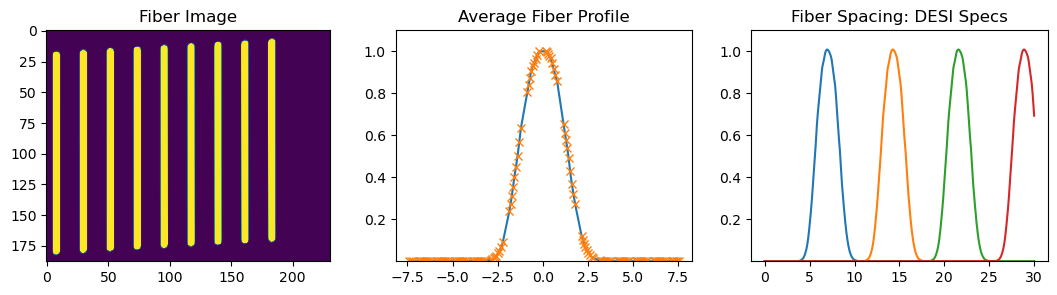

In [109]:
#print('b 3700')
fiber_density ('b', 3650.0)

### Display fiber plots for the blue channel at $\lambda = 5800 \unicode{x212B}$

Fiber Distance:  7.37287
Cross-Talk Determination:  0.000785731


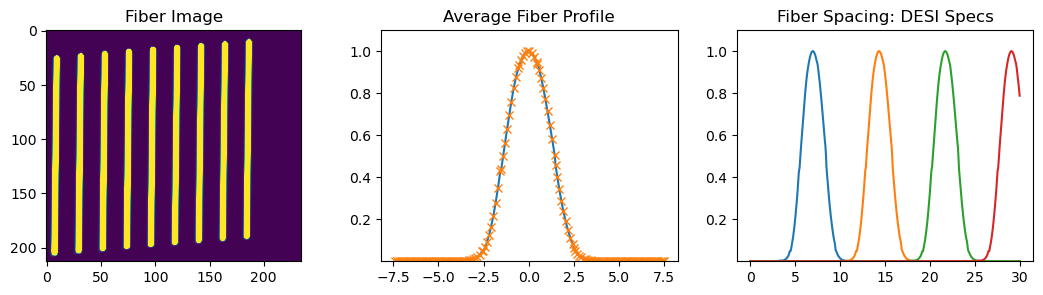

In [111]:
#print('b 5800')
fiber_density ('b', 5800.0)

### Display fiber plots for the NIR channel at $\lambda = 7530 \unicode{x212B}$

Fiber Distance:  7.29038
Cross-Talk Determination:  0.00125875


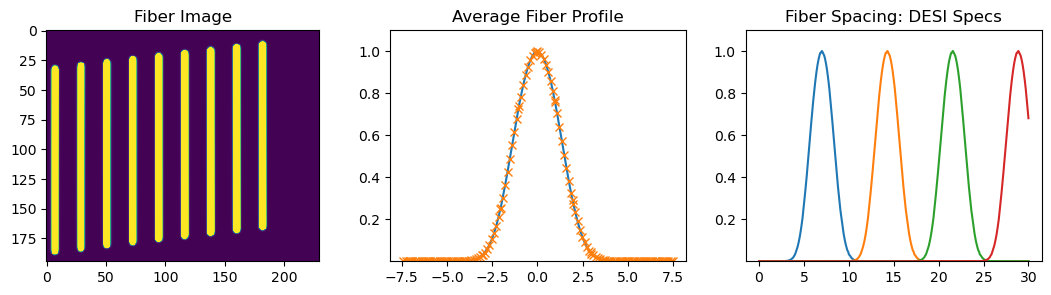

In [115]:
#print('z 7530')
fiber_density ('z', 7530.0)

### Display fiber plots for the NIR channel at $\lambda = 9800 \unicode{x212B}$

Fiber Distance:  7.3034
Cross-Talk Determination:  0.00467167


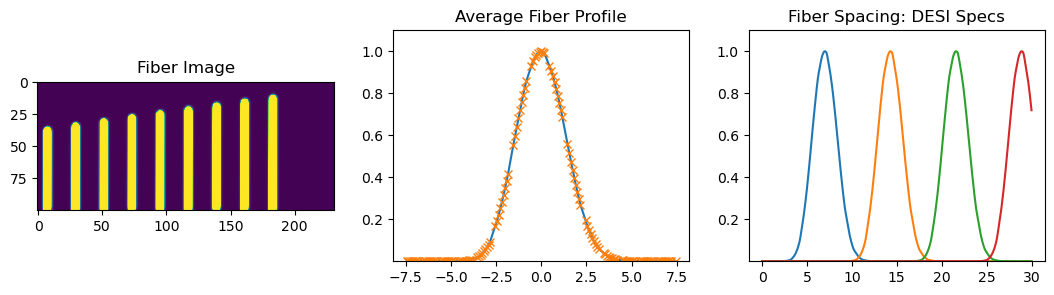

In [113]:
#print('z 9800')
fiber_density ('z', 9800.0)

### Additionally verify the average fiber distance for the blue ccd

Average Fiber Distance =  7.29167


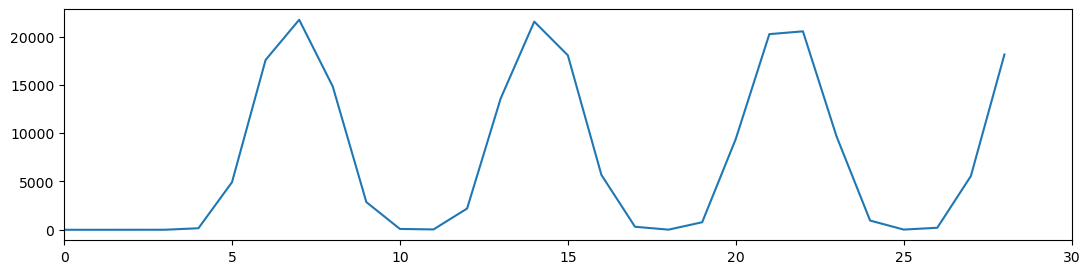

In [134]:
psfb = desimodel.io.load_psf('b')
b1 = get_image(psfb,3700.0,1)
x = b1[int(b1.shape[0]/2),]
# Plot a subset of fibers
fig, ax = plt.subplots(figsize = (13,3))
ax.set_xlim(xmin=0,xmax=30)
plt.plot(x[1:30])
# Determine the peaks
p = find_peaks(x[1:190])
# Calculate fiber distance
fiber_dist = np.average(np.diff(p))
print("Average Fiber Distance = ", "{:.6}".format(fiber_dist))

## Task 2: Simulation of a Two-Dimensional Arc Frame

#### Note that in addition to the code by N. Drory/G. Blanc, these tutotorials and software were also of benfit to this section of the notebook: the [SPECTRE Extract routines](https://github.com/desihub/specter/blob/main/py/specter/extract/ex1d.py) and the Astropy CCD Data Reduction and Stellar Photometry [User Guide](https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/00-00-Preface.html). 

In [6]:
def get_image(wave,phot,psf,sparse,nfib):
    '''
    This function will generate an image of nfib fibers at a given wavelength with the given psf
    Sparse=n populates every n-th fiber.
    Kind can be either 'flat' or 'arc'
        flat will generate a flat flux distribution
        arc will read a linelist and simulate an arc frame
    '''
    nwave = wave.size
    photons = np.zeros((nfib, nwave))
    # Make spectra sparse
    for i in range(int(nfib/sparse)):
        photons[i*sparse,] = phot
    # psf.xyrange() finds the range of CCD pixels affected by spectra and wavelengths in
    # some range of fiber number and wavelengths array
    xyrange = psf.xyrange([0,nfib], wave)
    truepix = psf.project(wave, photons, xyrange=xyrange).astype(np.float32)
    
    # Add noise
    rdnoise = 3
    truepix = np.random.poisson(truepix) + np.random.normal(scale=rdnoise, size=truepix.shape)

    return truepix.astype(np.float32)

def table_to_spectrum(wave,phot,w):
    '''
    Convert a list of wavelengths and values into a spectrum on the wavelength grid (w)
    the pixels in w closest to values in wave are set to phot.
    '''
    differences = (wave.reshape(1,-1) - w.reshape(-1,1))
    indices = np.abs(differences).argmin(axis=0)
    p = w*0.0
    p[indices] = phot
    #plot(w,p)
    #plot(wave,phot)
    
    return p

def sim_arc(channel,nfib,sparse):
    # Load DESI instrument configuration
    params = desimodel.io.load_desiparams()
    wavemin = params['ccd'][channel]['wavemin']
    print('wavemin= ',wavemin)
    wavemax = params['ccd'][channel]['wavemax']
    npix_y = params['ccd'][channel]['npix_y']
    dw = (wavemax-wavemin)/npix_y
    # Arc and flat data may be retrieved from desisim-testdata repository on desihub
    arc_fname = 'arc-lines-average-in-vacuum-from-winlight-20170118.fits'
    # flat_fname= 'flat-3100K-quartz-iodine.fits'
    file = os.path.join(os.getenv('DESI_TEST_DATA'), 'spectro', 'templates', 'calib', 'v0.4', arc_fname)
    data = Table.read(file)
    wave = data['VACUUM_WAVE']
    phot = data['ELECTRONS'] * 4.0 #simulate 4s exposure like the test data
    g = np.where((wave>=wavemin) & (wave<=wavemax))
    wave=wave[g]
    phot=phot[g]
    # Convert from table of lines to 'spectrum'
    w = np.linspace(wavemin,wavemax,npix_y*3)
    p = table_to_spectrum(wave,phot,w)
    # plt.plot(w,p)
    # plt.plot(wave,phot)
    # print (wave)
    # print (phot)

    # Load the PSF model for the channel
    psfx = desimodel.io.load_psf(channel)
    # Simulate the 2D image
    im = get_image(w,p,psfx,sparse,nfib)
    
    return im

### Simulate the arc frame for the RED channel

wavemin=  5564


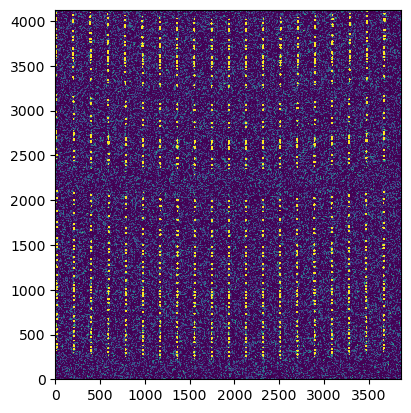

In [15]:
# Specify the channel
channel = 'r'
# Generate the image 
im = sim_arc(channel, 500, 25)
# Visualize the image
scale_args = dict(vmin=0, vmax=1)
extent = [0, im.shape[1], 0, im.shape[0]]
plt.imshow(im, origin='lower', cmap='viridis', extent=extent, aspect='equal', **scale_args)
# Save the generated image to file
fits.writeto('test_image_ccd-'+channel+'.fits', im, overwrite=True)

### Simulate the arc frame for the NIR channel

wavemin=  7360
wavemin=  7360


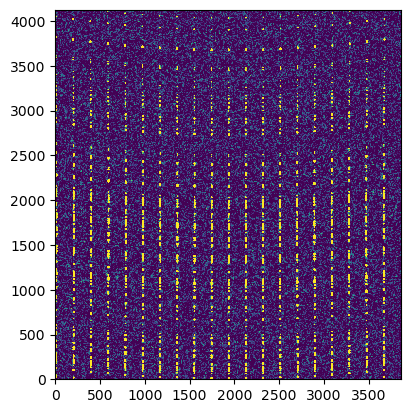

In [16]:
# Specify the channel
#Table.read.help() 
channel = 'z'
im = sim_arc(channel, 500, 25)
# Generate the image 
im = sim_arc(channel, 500, 25)
# Visualize the image
scale_args = dict(vmin=0, vmax=1)
extent = [0, im.shape[1], 0, im.shape[0]]
plt.imshow(im, origin='lower', cmap='viridis', extent=extent, aspect='equal', **scale_args)
# Save the generated image to file
fits.writeto('test_image_ccd-'+channel+'.fits', im, overwrite=True)